## **Waleed Umar (SP25-RAI-021)**

# **Paper Information**

**The paper selected was "Long-Term Coronary Artery Disease Risk Prediction with Machine Learning Models", published on 20 January 2023, in the HEC W Category ranked journal, Sensors.**

The paper is linked [here](https://www.mdpi.com/1424-8220/23/3/1193).

# **Replicating the Code**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import  StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
data = pd.read_csv('coronary_prediction.csv')

# **Preprocessing, Data cleaning and imputation**


In [3]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
data.shape

(4238, 16)

In [5]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
None
        

In [6]:
print(data.isnull().sum())

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


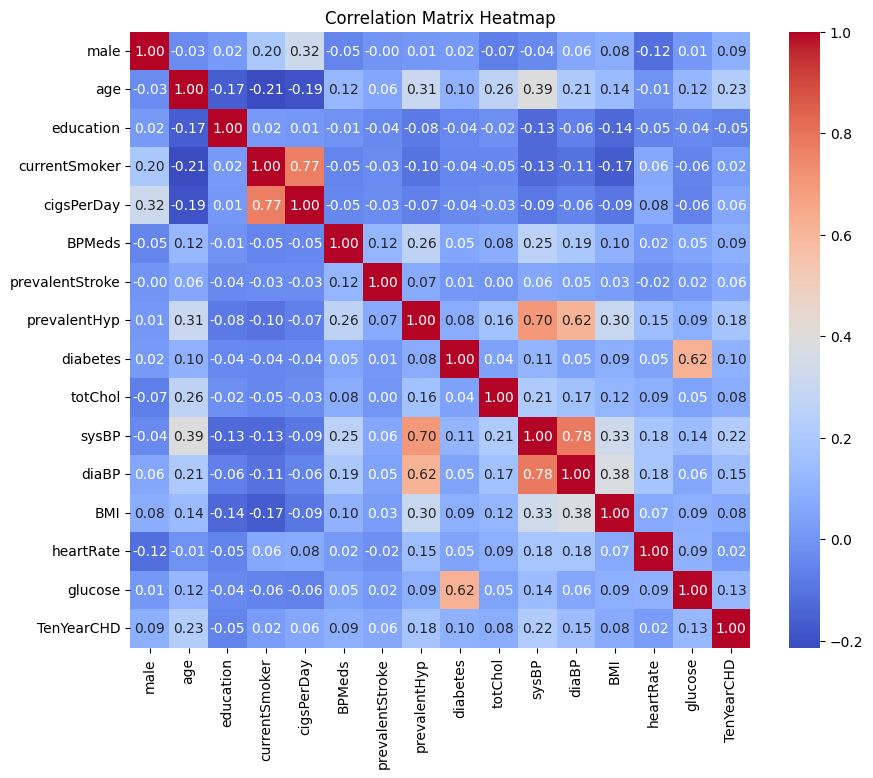

In [7]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [8]:
df_BPMed = data.groupby(['prevalentStroke','prevalentHyp'])
df_BPMed['BPMeds'].sum()

prevalentStroke  prevalentHyp
0                0                 0.0
                 1               117.0
1                0                 0.0
                 1                 7.0
Name: BPMeds, dtype: float64

It seems a prevalent Hyper tension patient are very likely to be on BPMed.

In [9]:
chol_col = ['totChol','BMI']
df_chol = data[chol_col]
df_chol[df_chol['BMI'] == 26]

,totChol,BMI
1507,265.0,26.0
1676,229.0,26.0
1731,241.0,26.0
1771,193.0,26.0
2241,239.0,26.0
3848,170.0,26.0
3908,206.0,26.0
4019,310.0,26.0


Cholestrol level are not correlated to any of the Independant Variables. Thus, option is to drop or impute with a mean or mode.

<Axes: xlabel='diaBP', ylabel='BMI'>

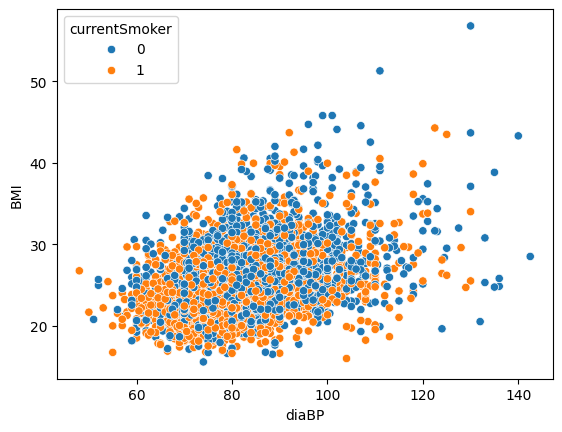

In [10]:
sns.scatterplot(x=data['diaBP'],y=data['BMI'],hue=data['currentSmoker'])


No direct relations were found between BMI and diaBP readings regardless of smoker or not.

In [11]:
df_diabetes = data.groupby(['diabetes'])
df_diabetes['glucose'].describe()

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,3745.0,79.489186,12.960078,40.0,71.0,78.0,86.0,163.0
1,105.0,170.333333,84.232242,47.0,110.0,145.0,215.0,394.0


### **Missing values**
  
Education level: Can be imputed with most frequent occurances in the data

cigs per day: Can be check with smoker status, if non smoker will be zero, else impute with mean

BPMeds: Likelihood that a patient with pavalent hyper tension is on BPMed

totChol: Will drop or impute with mean or mode

BMI: Since there are only a small percentage of missing value, will impute with the mean

heartrate: impute with mean

glucose: Will take the mean diabetes and non diabetes data

In [12]:
data['education'].mode()


0    1.0
Name: education, dtype: float64

In [13]:
data['education'] = data['education'].fillna(1)

In [14]:
df_smoker = data.groupby(['currentSmoker'])
df_smoker['cigsPerDay'].describe()

,count,mean,std,min,25%,50%,75%,max
currentSmoker,,,,,,,,
0,2144.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1,2065.0,18.350605,10.86595,1.0,10.0,20.0,20.0,70.0


In [15]:
data['cigsPerDay'] = data['cigsPerDay'].fillna(9999)

index = []

for i in data.index: 
    if data.loc[i, 'cigsPerDay'] == 9999:
        if data.loc[i, 'currentSmoker'] == 1:
            data.loc[i, 'cigsPerDay'] = 18  # Assign 18 for smokers
        else:
            data.loc[i, 'cigsPerDay'] = 0   # Assign 0 for non-smokers
        index.append(i)


In [16]:
data['BPMeds'] = data['BPMeds'].fillna(9999)  
index = []

for i in data.index:
    if data.loc[i, 'BPMeds'] == 9999:
        if data.loc[i, 'prevalentHyp'] == 1:
            data.loc[i, 'BPMeds'] = 1  # Assign 1 if prevalentHyp is 1
        else:
            data.loc[i, 'BPMeds'] = 0  # Assign 0 otherwise
        index.append(i)


In [17]:
data.totChol.describe()

count    4188.000000
mean      236.721585
std        44.590334
min       107.000000
25%       206.000000
50%       234.000000
75%       263.000000
max       696.000000
Name: totChol, dtype: float64

In [18]:
data['totChol'] = data['totChol'].fillna(236)  


In [19]:
data.BMI.describe()


count    4219.000000
mean       25.802008
std         4.080111
min        15.540000
25%        23.070000
50%        25.400000
75%        28.040000
max        56.800000
Name: BMI, dtype: float64

In [20]:
data['BMI'] = data['BMI'].fillna(25.8)  


In [21]:
data.heartRate.describe()


count    4237.000000
mean       75.878924
std        12.026596
min        44.000000
25%        68.000000
50%        75.000000
75%        83.000000
max       143.000000
Name: heartRate, dtype: float64

In [22]:
data['heartRate'] = data['heartRate'].fillna(75)  


In [23]:
data['glucose'] = data['glucose'].fillna(9999)  
index = []

for i in data.index:
    if data.loc[i, 'glucose'] == 9999:
        if data.loc[i, 'diabetes'] == 1:
            data.loc[i, 'glucose'] = 170  # Assign 170 if diabetes is 1
        else:
            data.loc[i, 'glucose'] = 79   # Assign 79 otherwise
        index.append(i)


In [24]:
print("\nMissing Values After Imputation:")
print(data.isnull().sum())


Missing Values After Imputation:
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


# **EDA**

In [25]:
counts= data['TenYearCHD'].value_counts()
print(counts)

TenYearCHD
0    3594
1     644
Name: count, dtype: int64


In [26]:
PerCounts= data['TenYearCHD'].value_counts()/4238
print(PerCounts)

TenYearCHD
0    0.848042
1    0.151958
Name: count, dtype: float64


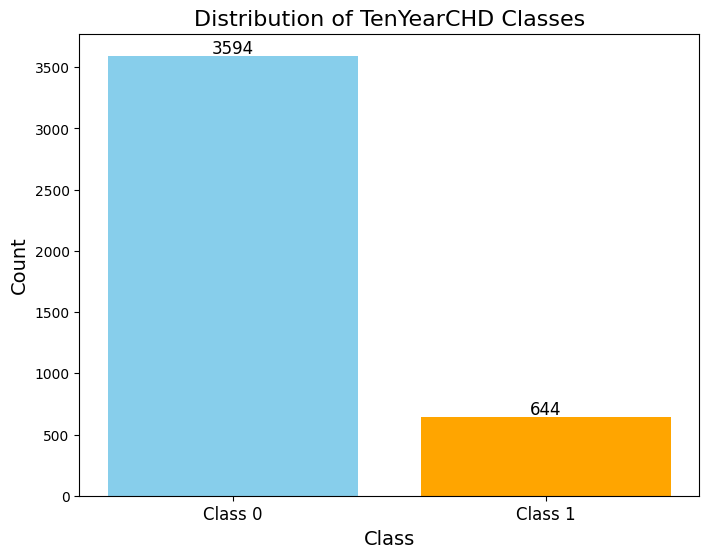

In [27]:
class_counts = data['TenYearCHD'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'orange'])

plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of TenYearCHD Classes', fontsize=16)
plt.xticks(ticks=class_counts.index, labels=[f'Class {i}' for i in class_counts.index], fontsize=12)

for i, count in enumerate(class_counts.values):
    plt.text(x=i, y=count + 20, s=f"{count}", ha='center', fontsize=12)

plt.show()

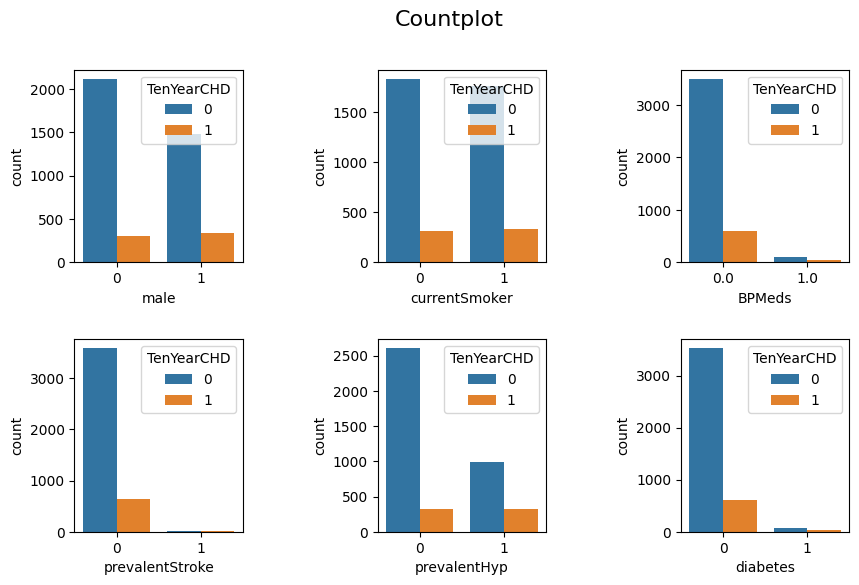

In [28]:
count_col = ['male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

fig, axes = plt.subplots(2,3, figsize=(10,6))
fig.subplots_adjust(hspace=0.4,wspace=0.8)

fig.suptitle('Countplot',fontsize=16)

i=0
n=0

for x in count_col:
    sns.countplot(x=data[x],hue=data['TenYearCHD'],ax=axes[i,n])
    
    if n < 2:
        n+=1
    else:
        n=0
        i+=1
plt.show()


In [29]:
df_CHD = data.groupby(['TenYearCHD'])
df_CHD[count_col].sum()

,male,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes
TenYearCHD,,,,,,
0,1476,1761,98.0,14,991,69
1,343,333,48.0,11,325,40


From the data, it appears

- Male patient carry a slightly higher risk
- A smoker carry a slightly higher risk
- Patient on BP medication carry a much higher risk
- Patient with prevalent stroke history carry a much higher risk
- There is a higher risk between pavalent hyper tension
- Patients with diabetes carry a higher risk

<Axes: xlabel='education', ylabel='count'>

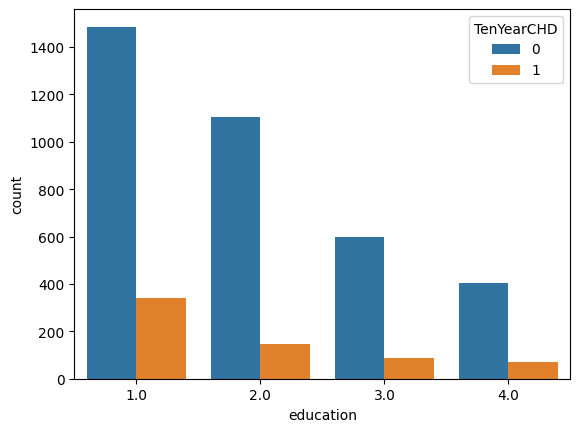

In [30]:
sns.countplot(x=data['education'],hue=data['TenYearCHD'])


<Axes: xlabel='male', ylabel='count'>

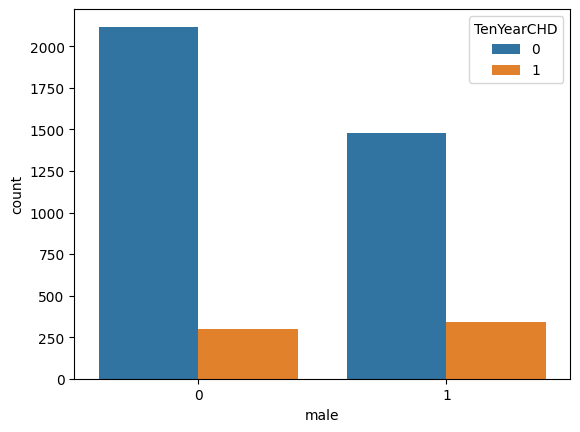

In [31]:
sns.countplot(x=data['male'],hue=data['TenYearCHD'])

In [32]:
df_CHD['education'].value_counts()

TenYearCHD  education
0           1.0          1486
            2.0          1106
            3.0           599
            4.0           403
1           1.0           339
            2.0           147
            3.0            88
            4.0            70
Name: count, dtype: int64

In [33]:
data['education'].value_counts()


education
1.0    1825
2.0    1253
3.0     687
4.0     473
Name: count, dtype: int64

There seem to be a slight increase of risk as lower education received.

<Axes: xlabel='age', ylabel='count'>

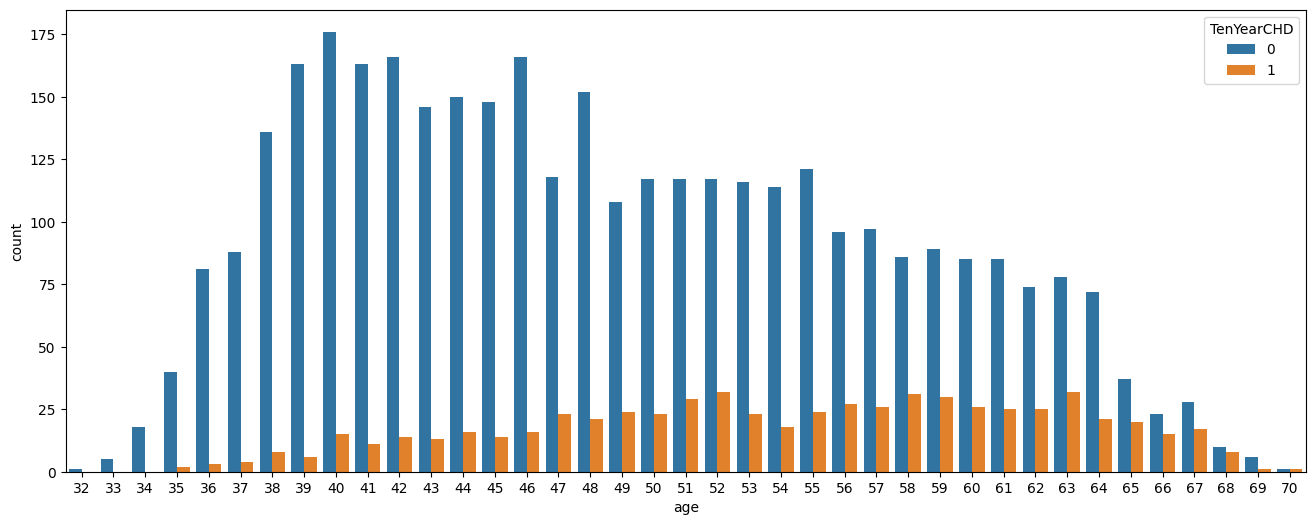

In [34]:
plt.figure(figsize=(16,6))
sns.countplot(x=data['age'],hue=data['TenYearCHD'])

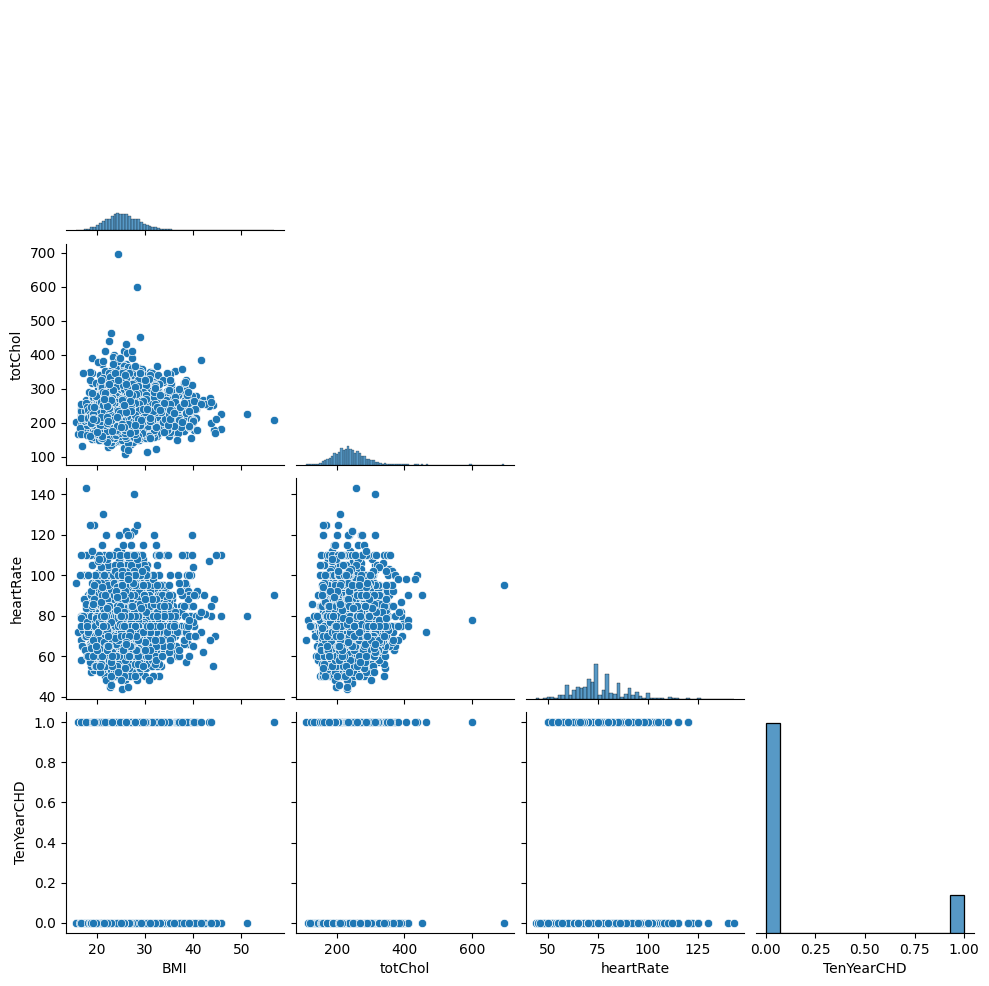

In [35]:
num_col = ['BMI','totChol','heartRate','TenYearCHD']
sns.pairplot(data[num_col],corner=True)

There is not a distint correlation between the Independant Variables and the Dependant Variable.

**Conclusion**

The risk varies with age but also with certain health patterns as explored above.

## **Feature Importance Analysis**

In [36]:
X = data.drop(columns=['TenYearCHD'])  
y = data['TenYearCHD']

In [37]:
smote = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [39]:
print("Original Data Split:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

print("SMOTE Data Split:")
print(f"X_train_smote: {X_train_smote.shape}, X_test_smote: {X_test_smote.shape}, y_train_smote: {y_train_smote.shape}, y_test_smote: {y_test_smote.shape}")

Original Data Split:
X_train: (3390, 15), X_test: (848, 15), y_train: (3390,), y_test: (848,)
SMOTE Data Split:
X_train_smote: (5750, 15), X_test_smote: (1438, 15), y_train_smote: (5750,), y_test_smote: (1438,)


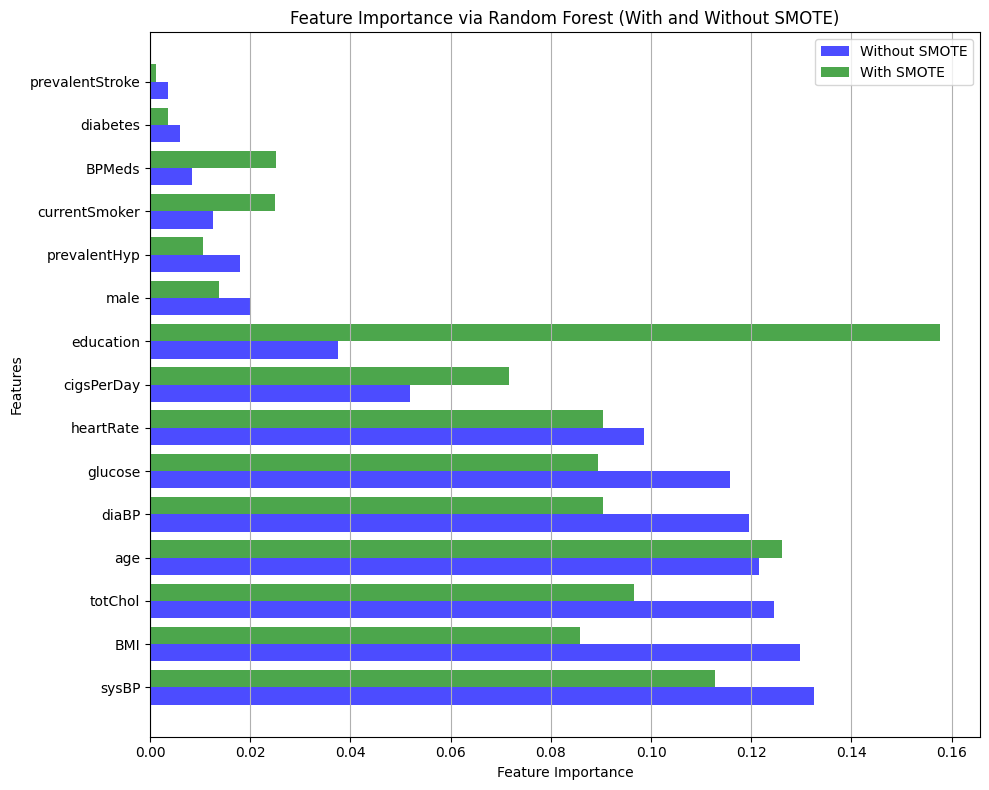

In [70]:
def compute_feature_importance(X, y):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    return pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Compute Feature Importance Without SMOTE (using original scaled data)
feature_importance_df_no_smote =  compute_feature_importance(X_train, y_train)
feature_importance_df_no_smote.rename(columns={'Importance': 'Importance Without SMOTE'}, inplace=True)

# Compute Feature Importance With SMOTE (using resampled data)
feature_importance_df_smote = compute_feature_importance(X_train_smote, y_train_smote)
feature_importance_df_smote.rename(columns={'Importance': 'Importance With SMOTE'}, inplace=True)

feature_importance_combined = pd.merge(
    feature_importance_df_no_smote, feature_importance_df_smote, on='Feature'
)

plt.figure(figsize=(10, 8))
bar_height = 0.4
y_pos = range(len(feature_importance_combined['Feature']))

plt.barh(y_pos, feature_importance_combined['Importance Without SMOTE'], height=bar_height, label='Without SMOTE', color='blue', alpha=0.7)
plt.barh(
    [p + bar_height for p in y_pos],
    feature_importance_combined['Importance With SMOTE'],
    height=bar_height,
    label='With SMOTE',
    color='green',
    alpha=0.7,
)

plt.yticks([p + bar_height / 2 for p in y_pos], feature_importance_combined['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance via Random Forest (With and Without SMOTE)')
plt.legend()
plt.tight_layout()
plt.grid(axis='x')
plt.show()


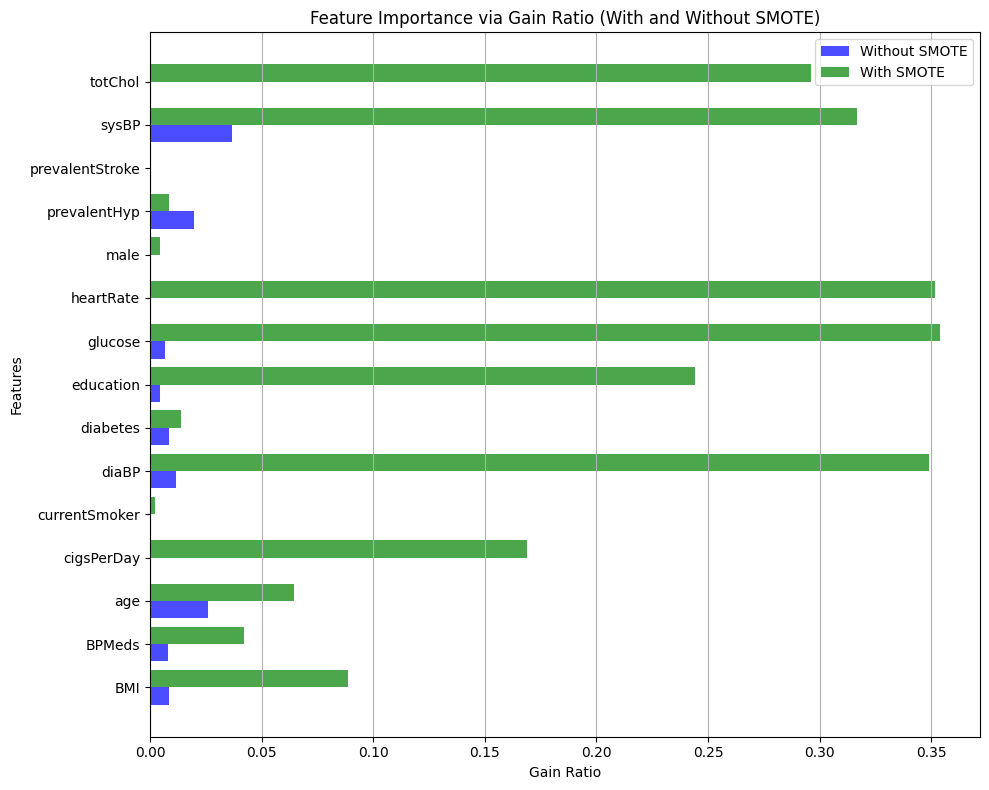

In [30]:
def compute_gain_ratio(X, y):
    gain_ratios = mutual_info_classif(X, y, discrete_features=False)
    return pd.DataFrame({'Feature': X.columns, 'Gain Ratio': gain_ratios}).sort_values(by='Feature')


# Compute Gain Ratios Without SMOTE
gain_ratio_df_no_smote = compute_gain_ratio(X_train, y_train)
gain_ratio_df_no_smote.rename(columns={'Gain Ratio': 'Gain Ratio Without SMOTE'}, inplace=True)

# Compute Gain Ratios With SMOTE
gain_ratio_df_smote = compute_gain_ratio(X_train_smote, y_train_smote)
gain_ratio_df_smote.rename(columns={'Gain Ratio': 'Gain Ratio With SMOTE'}, inplace=True)

gain_ratio_combined = pd.merge(
    gain_ratio_df_no_smote, gain_ratio_df_smote, on='Feature'
)

plt.figure(figsize=(10, 8))
bar_height = 0.4
y = range(len(gain_ratio_combined['Feature']))

plt.barh(y, gain_ratio_combined['Gain Ratio Without SMOTE'], height=bar_height, label='Without SMOTE', color='blue', alpha=0.7)
plt.barh(
    [p + bar_height for p in y],
    gain_ratio_combined['Gain Ratio With SMOTE'],
    height=bar_height,
    label='With SMOTE',
    color='green',
    alpha=0.7,
)

plt.yticks([p + bar_height / 2 for p in y], gain_ratio_combined['Feature'])
plt.ylabel('Features')
plt.xlabel('Gain Ratio')
plt.title('Feature Importance via Gain Ratio (With and Without SMOTE)')
plt.legend()
plt.tight_layout()
plt.grid(axis='x')
plt.show()

# **Model Building & Evaluation**

In [40]:
models = {
    "3-NN": KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean'),
    "Bagging": BaggingClassifier(RandomForestClassifier(n_estimators=500, random_state=42), n_estimators=10, random_state=42),
    "Decision Tree (J48)": DecisionTreeClassifier(random_state=42, criterion='gini', splitter='best', max_depth=None),
    "Logistic Regression (LR)": LogisticRegression(C=1e8, solver='lbfgs', max_iter=1000, random_state=42),
    "MLP (Multilayer Perceptron)": MLPClassifier(learning_rate_init=0.1, momentum=0.2, max_iter=200, random_state=42),
    "Naive Bayes (NB)": GaussianNB(),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42, max_samples=1.0),
     "Stacking": StackingClassifier(estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('nb', GaussianNB())
    ], final_estimator=LogisticRegression(C=1e8, solver='lbfgs', random_state=42)),
    "Voting": VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('nb', GaussianNB())
    ], voting='soft')
   
}


In [41]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    return metrics


In [74]:
results = {"Original Data": {}, "SMOTE Data": {}}

# Evaluate each model on the original (imbalanced) data
for name, model in models.items():
    results["Original Data"][name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# Evaluate each model on the SMOTE-balanced data
for name, model in models.items():
    results["SMOTE Data"][name] = evaluate_model(model, X_train_smote, X_test_smote, y_train_smote, y_test_smote)


C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of it

In [75]:
original_results_df = pd.DataFrame(results["Original Data"]).T
smote_results_df = pd.DataFrame(results["SMOTE Data"]).T

In [76]:
print("Original Data Results:")
print(original_results_df)

Original Data Results:
                             Accuracy  Precision    Recall       AUC
3-NN                         0.812500   0.213115  0.104839  0.559426
Bagging                      0.854953   0.538462  0.056452  0.692719
Decision Tree (J48)          0.746462   0.202614  0.250000  0.540746
Logistic Regression (LR)     0.859670   0.647059  0.088710  0.710101
MLP (Multilayer Perceptron)  0.853774   0.000000  0.000000  0.500000
Naive Bayes (NB)             0.823113   0.324324  0.193548  0.714779
Random Forest (RF)           0.856132   0.562500  0.072581  0.681034
Stacking                     0.852594   0.476190  0.080645  0.681151
Voting                       0.821934   0.304348  0.169355  0.686720


In [77]:
print("\nSMOTE Data Results:")
print(smote_results_df)


SMOTE Data Results:
                             Accuracy  Precision    Recall       AUC
3-NN                         0.814325   0.723586  0.988338  0.906219
Bagging                      0.894993   0.888244  0.892128  0.962945
Decision Tree (J48)          0.819889   0.792867  0.842566  0.820884
Logistic Regression (LR)     0.674548   0.645333  0.705539  0.739935
MLP (Multilayer Perceptron)  0.477051   0.477051  1.000000  0.500000
Naive Bayes (NB)             0.612656   0.651054  0.405248  0.699970
Random Forest (RF)           0.908901   0.912333  0.895044  0.969476
Stacking                     0.917246   0.927602  0.896501  0.965606
Voting                       0.761474   0.798261  0.669096  0.877278


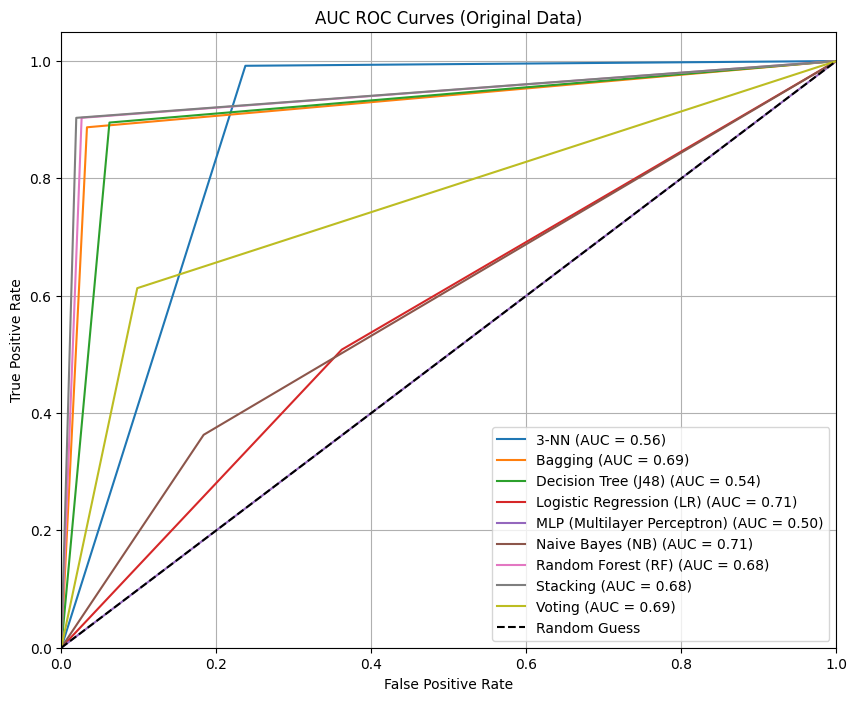

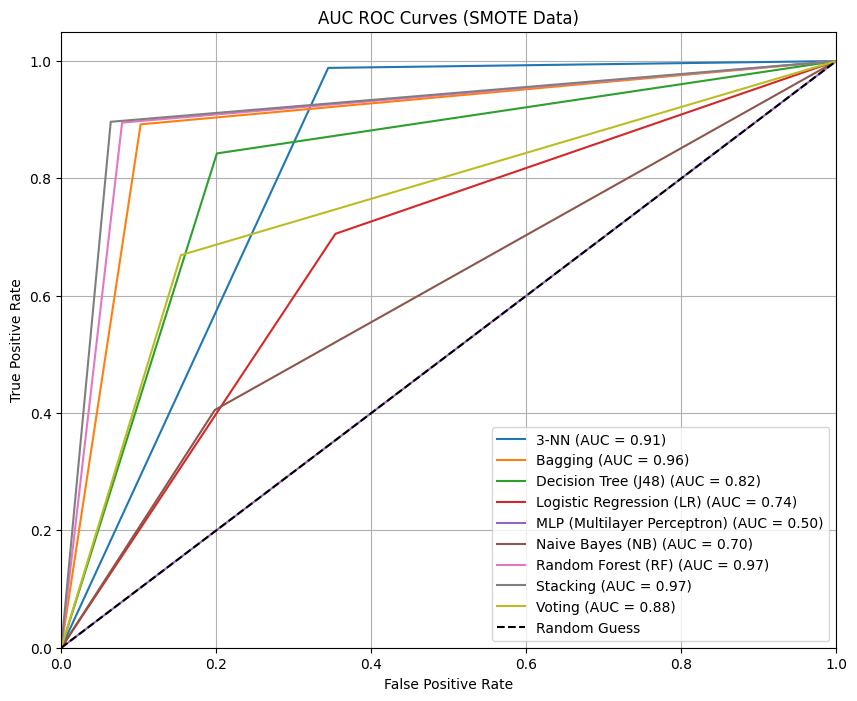

In [80]:
def plot_roc_curves_from_results(models, X_test, y_test, results_df, title):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        if name in results_df.index: 
            auc_score = results_df.loc[name, 'AUC']
            y_pred = model.predict(X_test)  
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC curves for Original Data (No SMOTE)
plot_roc_curves_from_results(models, X_test, y_test, original_results_df, "AUC ROC Curves (Original Data)")

# Plot ROC curves for SMOTE Data
plot_roc_curves_from_results(models, X_test_smote, y_test_smote, smote_results_df, "AUC ROC Curves (SMOTE Data)")


In [44]:
stacking_model = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('nb', GaussianNB())
], final_estimator=LogisticRegression(C=1e8, solver='lbfgs', random_state=42))


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(stacking_model, X_smote, y_smote, cv=cv, scoring='roc_auc')

print(f'10-Fold Cross-Validation AUC Scores: {cv_scores}')
print(f'Mean AUC: {cv_scores.mean():.4f}')

10-Fold Cross-Validation AUC Scores: [0.98089601 0.97291086 0.97069793 0.97860569 0.97191272 0.95965645
 0.97994429 0.95861962 0.97098874 0.96961538]
Mean AUC: 0.9714


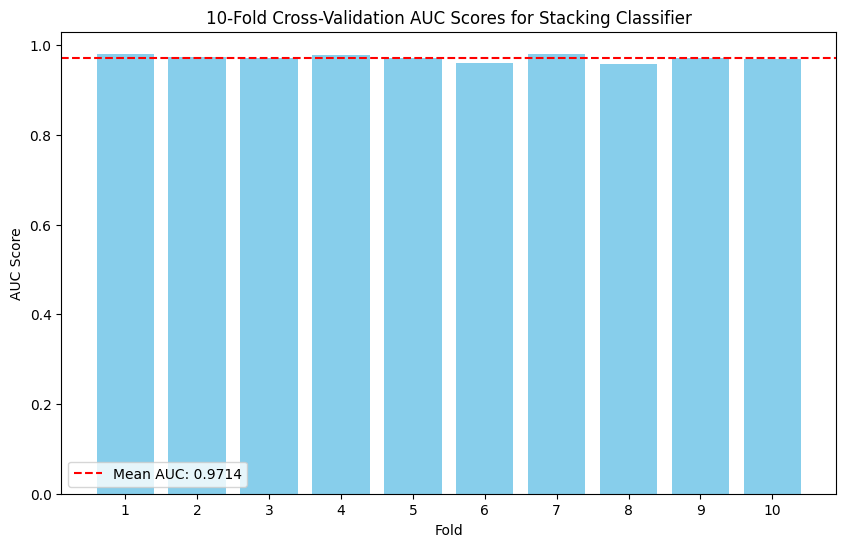

In [45]:
plt.figure(figsize=(10, 6))
folds = np.arange(1, len(cv_scores) + 1)
plt.bar(folds, cv_scores, color='skyblue')

mean_score = np.mean(cv_scores)
plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean AUC: {mean_score:.4f}')

# Labels and title
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.title('10-Fold Cross-Validation AUC Scores for Stacking Classifier')
plt.xticks(folds)
plt.legend()
plt.show()

# **Why is there a difference in results?**

- The dataset referenced by the authors in their paper was originally a public dataset on Kaggle. However, at the time the authors utilized it, the dataset contained 3,655 instances, whereas the current version contains 4,238 instances.
- This discrepancy has led to differences in the results of Gain Ratio Feature Importance and Random Forest Feature Ranking between the paper's findings and my implementation.
- The authors did not specify what methods they used for imputation of missing values.
- Naturally, this variation in dataset size also influenced the performance and results of the models.
- The authors identified the Stacking Model with SMOTE as the best-performing approach, the same is the result for my implementation.